In [1]:
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Config

In [2]:
target_gauge_id = 3465
predict_next_hours = 12

### Data Loading

In [3]:
data = pd.read_csv(f"../dataset/processed/simple/{target_gauge_id}/{predict_next_hours}.gz")
data.dropna(how="any", inplace=True)

In [4]:
x_data = data.loc[:, (data.columns != "DATE") & (data.columns != "TARGET")]
y_data = data["TARGET"]

In [5]:
x_data

,DISTANCE_0,DISTANCE_1,DISTANCE_2,DISTANCE_3,DISTANCE_4,DISTANCE_5,DISTANCE_6,DISTANCE_7,DISTANCE_8,DISTANCE_9,...,LEVEL_9_62,LEVEL_9_63,LEVEL_9_64,LEVEL_9_65,LEVEL_9_66,LEVEL_9_67,LEVEL_9_68,LEVEL_9_69,LEVEL_9_70,LEVEL_9_71
0,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,78.500000,78.333333,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667
1,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,78.333333,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333
2,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,80.166667,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667
3,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,81.666667,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667,59.500000
4,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,81.666667,82.500000,84.166667,79.000000,71.166667,69.166667,68.333333,62.166667,59.500000,59.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11575,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,81.833333,73.500000,82.166667,94.000000,95.000000,95.333333,95.333333,95.166667,93.333333,92.000000
11576,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,73.500000,82.166667,94.000000,95.000000,95.333333,95.333333,95.166667,93.333333,92.000000,92.000000
11577,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,82.166667,94.000000,95.000000,95.333333,95.333333,95.166667,93.333333,92.000000,92.000000,92.666667
11578,0.0,47.974465,47.701469,23.750652,29.836259,11.215813,21.741801,40.931579,7.65356,19.327307,...,94.000000,95.000000,95.333333,95.333333,95.166667,93.333333,92.000000,92.000000,92.666667,94.833333


In [6]:
y_data

0        149.166667
1        150.666667
2        150.666667
3        145.833333
4        141.833333
            ...    
11575    138.666667
11576    139.166667
11577    140.166667
11578    141.000000
11579    141.166667
Name: TARGET, Length: 11079, dtype: float64

### Data Processing

In [7]:
# Split datasets into train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

# Normalize datasets with scaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [8]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### Model Setup

In [9]:
# Instantiate the model
model = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] * 2),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] * 2, x_train_tensor.shape[1]),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1], x_train_tensor.shape[1] // 4),
    nn.ReLU(),
    nn.Linear(x_train_tensor.shape[1] // 4, 1),
    nn.Softplus(),
)

### Model Loading

In [10]:
directory = f"../models/simple/{target_gauge_id}"

# Load our scaler
scaler = load(f"{directory}/{predict_next_hours}.bin")

# Load our model
model.load_state_dict(torch.load(f"{directory}/{predict_next_hours}.pth", map_location=torch.device("cpu")))
model.eval()

Sequential(
  (0): Linear(in_features=730, out_features=1460, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1460, out_features=730, bias=True)
  (3): ReLU()
  (4): Linear(in_features=730, out_features=182, bias=True)
  (5): ReLU()
  (6): Linear(in_features=182, out_features=1, bias=True)
  (7): Softplus(beta=1.0, threshold=20.0)
)

### Model Explaining

In [11]:
x_samples_main = x_train_tensor[torch.randint(len(x_train_tensor), (1000,))]
x_samples_values = x_train_tensor[torch.randint(len(x_train_tensor), (500,))]

In [12]:
explainer = shap.DeepExplainer(model, x_samples_main)
shap_values = explainer.shap_values(x_samples_values)
shap_values = np.squeeze(shap_values)

In [13]:
shap_df = pd.DataFrame({
    "mean_abs_shap": np.mean(np.abs(shap_values), axis=0), 
    "stdev_abs_shap": np.std(np.abs(shap_values), axis=0), 
    "name": data.columns[2:],
})
shap_df.sort_values("mean_abs_shap", ascending=False)

,mean_abs_shap,stdev_abs_shap,name
225,6.751802,7.211544,LEVEL_2_71
585,6.465485,6.101712,LEVEL_7_71
298,4.252697,3.608077,LEVEL_4_0
369,3.946838,3.398993,LEVEL_4_71
153,3.946710,4.178042,LEVEL_1_71
...,...,...,...
5,0.000000,0.000000,DISTANCE_5
6,0.000000,0.000000,DISTANCE_6
1,0.000000,0.000000,DISTANCE_1
7,0.000000,0.000000,DISTANCE_7


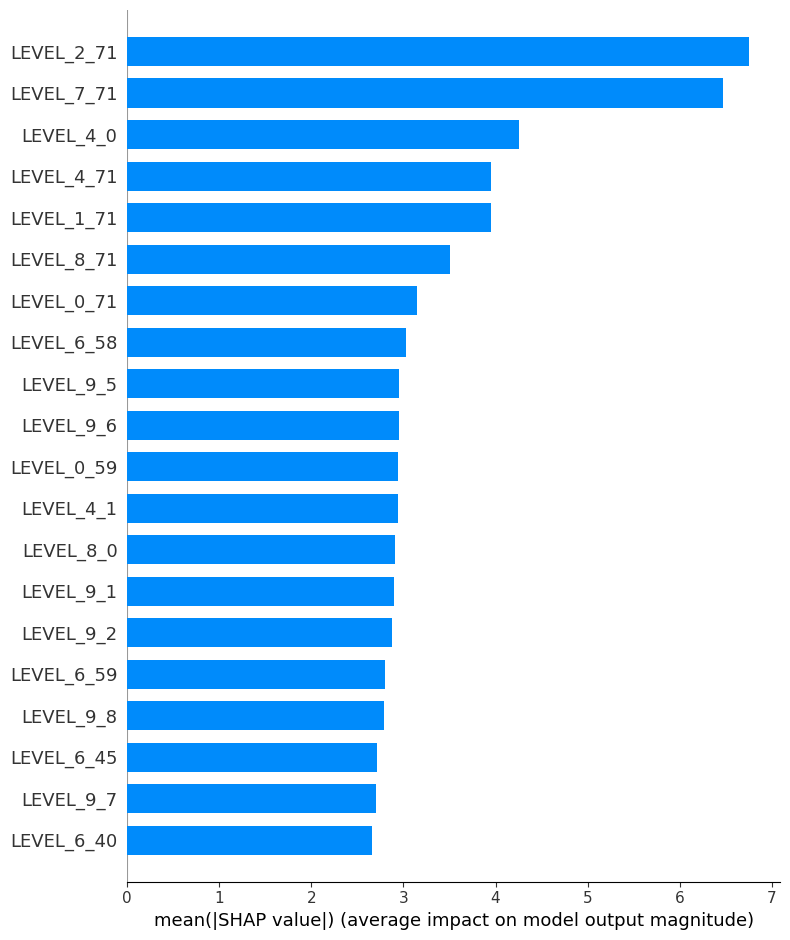

In [14]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="bar")

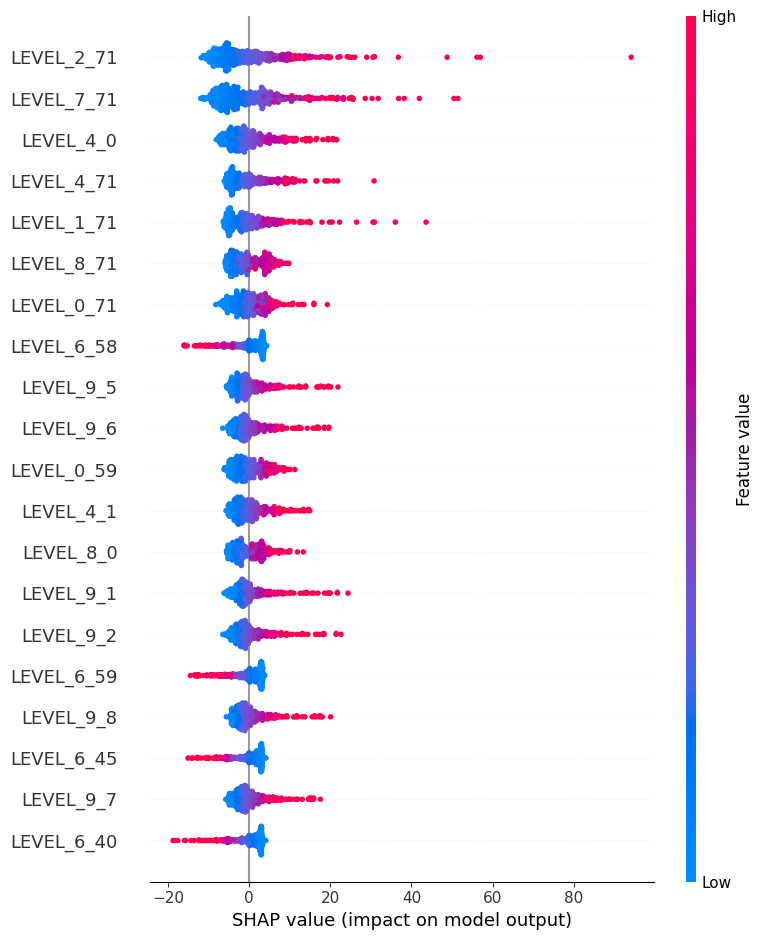

In [15]:
shap.summary_plot(shap_values, features=x_samples_values, feature_names=data.columns[2:], plot_type="dot")

### Model Evaluation

In [16]:
with torch.no_grad():
    y_pred = pd.DataFrame(model(x_test_tensor).numpy(), columns=["PREDICTION"])
    results = pd.merge(y_test.reset_index(drop=True), y_pred, left_index=True, right_index=True)

In [17]:
results["DIFF"] = (results["TARGET"] - results["PREDICTION"])**2

In [18]:
results

,TARGET,PREDICTION,DIFF
0,244.833333,243.107513,2.978454e+00
1,167.833333,166.921509,8.314240e-01
2,175.666667,176.241638,3.305922e-01
3,344.833333,346.935974,4.421098e+00
4,145.500000,144.533401,9.343127e-01
...,...,...,...
3319,244.666667,244.666855,3.541613e-08
3320,166.000000,165.761124,5.706191e-02
3321,172.000000,171.336304,4.404928e-01
3322,213.166667,214.079987,8.341532e-01


In [19]:
print("MSE: %.2f" % results["DIFF"].mean())
print("RMSE: %.2f" % np.sqrt(results["DIFF"].mean()))

MSE: 20.56
RMSE: 4.53
